In [1]:
#!pip install hdbscan
#!pip install yellowbrick
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans
import warnings
import statistics
from sklearn.cluster import HDBSCAN

In [2]:
file = "./Champo Carpets V1.csv"
data = pd.read_csv(file)
data.head(3)

,OrderiD,Item_Id,CustomerCode,CountryName,customer_country,QtyRequired,TotalArea,Amount,ITEM_NAME,QualityName,DesignName,ColorName,ShapeName
0,1,5,H-1,USA,H-1USA,6,128.25,769.5,HAND TUFTED,TUFTED 30C HARD TWIST,OLD LONDON [3715],GREEN/IVORY,REC
1,1,26,H-1,USA,H-1USA,6,117.00,702.0,HAND TUFTED,TUFTED 60C,DUDLEY [9012],BEIGE,REC
2,1,17,H-1,USA,H-1USA,7,88.00,616.0,HAND TUFTED,TUFTED 60C,WEMBLY [CC-206],BEIGE/SAGE,REC


# Exploratory Data Analysis

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13135 entries, 0 to 13134
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   OrderiD           13135 non-null  int64  
 1   Item_Id           13135 non-null  int64  
 2   CustomerCode      13135 non-null  object 
 3   CountryName       13135 non-null  object 
 4   customer_country  13135 non-null  object 
 5   QtyRequired       13135 non-null  int64  
 6   TotalArea         13135 non-null  float64
 7   Amount            13135 non-null  float64
 8   ITEM_NAME         13135 non-null  object 
 9   QualityName       13135 non-null  object 
 10  DesignName        13135 non-null  object 
 11  ColorName         13135 non-null  object 
 12  ShapeName         13135 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 1.3+ MB


In [4]:
print("\nSummary Statistics - Customer Data:")
data.describe()


Summary Statistics - Customer Data:


,OrderiD,Item_Id,QtyRequired,TotalArea,Amount
count,13135.000000,13135.000000,13135.000000,13135.000000,13135.000000
mean,3075.336962,14528.683746,44.460601,44.731370,2392.040164
std,2107.731646,13183.139544,228.749535,50.099597,16832.091080
min,1.000000,1.000000,1.000000,0.040000,0.000000
25%,1219.500000,3023.000000,3.000000,5.800000,163.200000
50%,2934.000000,8631.000000,8.000000,24.000000,590.625000
75%,4630.000000,26713.000000,20.000000,80.000000,1540.000000
max,7548.000000,46701.000000,6400.000000,1024.000000,599719.680000


In [5]:
data = data[~data['ITEM_NAME'].str.contains('-')]          # Removing the rows where item name is '-'

In [6]:
data = data[data['Amount']!=0.00]                          # Removing the rows where Amount is 0

In [7]:
print("length of data",data.shape[0])

length of data 12577


In [8]:
print("Number of Unique Customers",len(data.CustomerCode.unique()))

Number of Unique Customers 45


#### 1. Analysis of Cost Amount per Area wrt Items

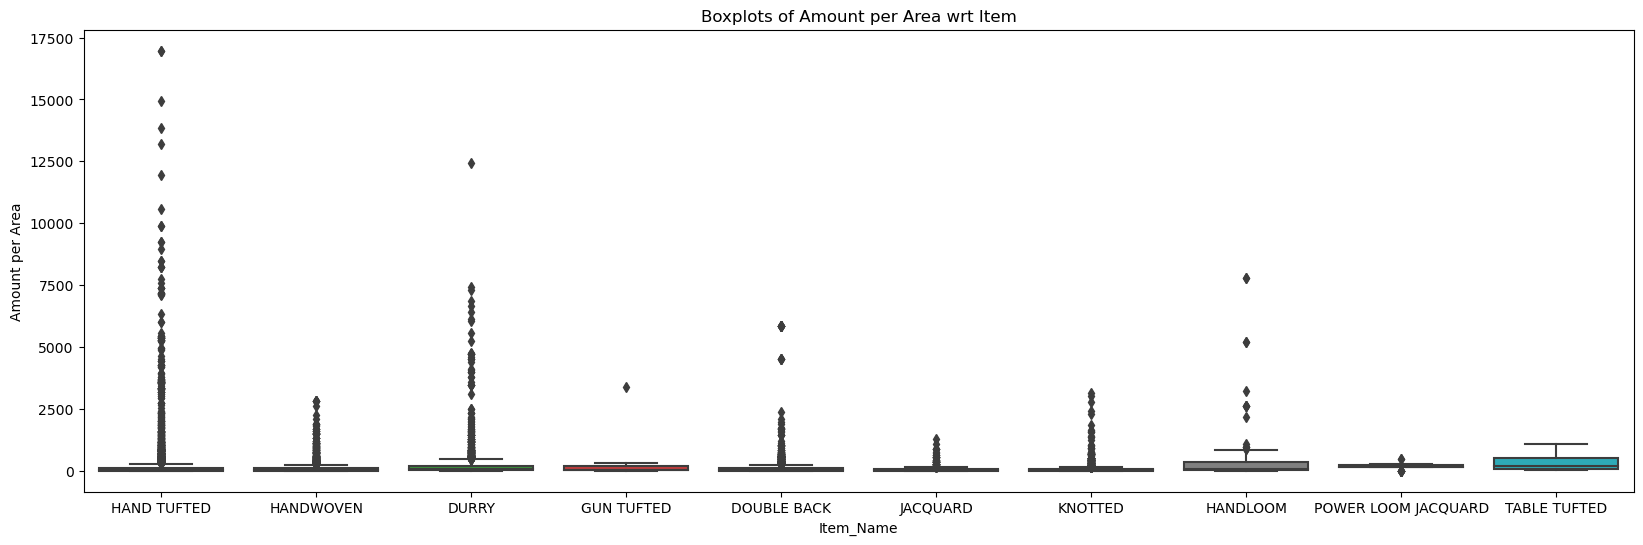

In [9]:
data.sort_values(by=['Amount'])
data['Amt_per_Area'] = data['Amount']/data['TotalArea'] # creating a new column to determine Cost Amt per Area

item_bins = data.ITEM_NAME.unique()
item_bins.sort()
                                                        # Analysis of Cost Amt per Area wrt Items 
plt.figure(figsize=(20, 6))                              
sns.boxplot(x='ITEM_NAME', y='Amt_per_Area', data=data)
plt.title('Boxplots of Amount per Area wrt Item')
plt.xlabel('Item_Name')
plt.ylabel('Amount per Area')
plt.show()

#### 2. We are exploring which designs are expensive or cheap wrt to Cost Amount per Area

In [10]:
print("The count of Unique designs is ",len(data.DesignName.unique()),"\n")
df_design_cost = data.groupby(['DesignName']).agg({'Amt_per_Area':'mean'}).reset_index().sort_values('Amt_per_Area')
print(df_design_cost)

The count of Unique designs is  923 

           DesignName  Amt_per_Area
390     CHINDI-STAIRE      0.500000
284     ASSORTED-VISC      0.850000
903              WINE      1.000000
774      REGAL [9051]      1.000000
775    REGAL [C-4484]      1.000000
..                ...           ...
803      SEAS THE DAY   9894.736842
479      FOLKSY WHALE   9894.736842
110             10577  12444.444444
898    WELCOME SHELLS  13192.982456
857  THREE PINEAPPLES  13852.631579

[923 rows x 2 columns]


             ITEM_NAME  Amt_per_Area  Amt_per_Qnty
6             JACQUARD     84.206659    159.620321
7              KNOTTED     91.655150    250.324710
0          DOUBLE BACK    144.354285    195.947868
5            HANDWOVEN    146.506800    151.271377
2           GUN TUFTED    168.140704    173.043889
8  POWER LOOM JACQUARD    176.106667      8.691667
1                DURRY    223.078635     66.361820
3          HAND TUFTED    275.123827    216.606815
4             HANDLOOM    346.812142    143.226589
9         TABLE TUFTED    356.400000     72.900000


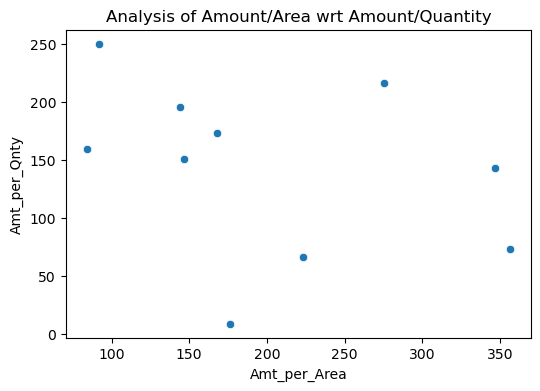

In [11]:
data.sort_values(by=['Amount'])
data['Amt_per_Qnty'] = data['Amount']/data['QtyRequired']
df_item_cost = data.groupby(['ITEM_NAME']).agg({'Amt_per_Area':'mean',
                                                   'Amt_per_Qnty':'mean'}).reset_index().sort_values('Amt_per_Area')
print(df_item_cost)
plt.figure(figsize=(6, 4))  
sns.scatterplot(x=df_item_cost['Amt_per_Area'], y=df_item_cost['Amt_per_Qnty']
                #, hue=df_item_cost['ITEM_NAME']
               )

plt.title('Analysis of Amount/Area wrt Amount/Quantity')
plt.xlabel('Amt_per_Area')
plt.ylabel('Amt_per_Qnty')
plt.show()

#### 3. Analysis of Amount per Quantity wrt to Items

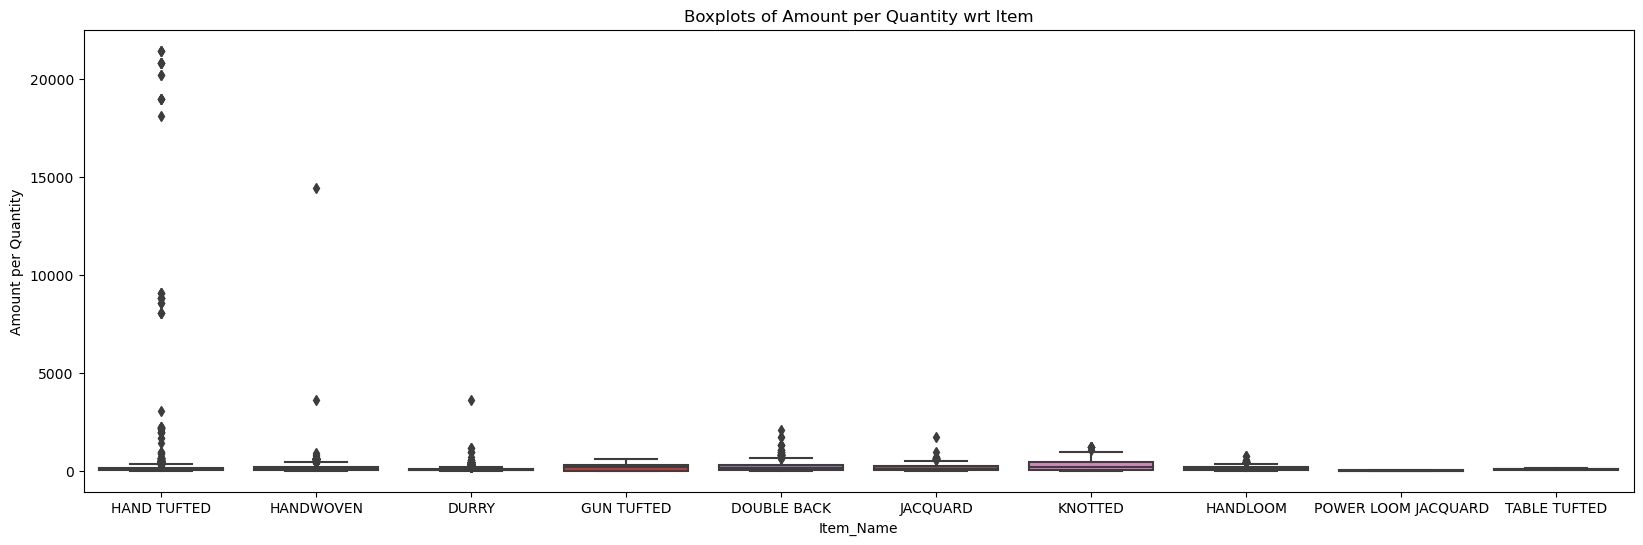

In [12]:
item_bins = data.ITEM_NAME.unique()
item_bins.sort()

plt.figure(figsize=(20, 6))
sns.boxplot(x='ITEM_NAME', y='Amt_per_Qnty', data=data)
plt.title('Boxplots of Amount per Quantity wrt Item')
plt.xlabel('Item_Name')
plt.ylabel('Amount per Quantity')
plt.show()

#### 4. Histogram to determine the Amount per Quantity and Histogram to determine Amount per Area, and for what quantity, most items are bought

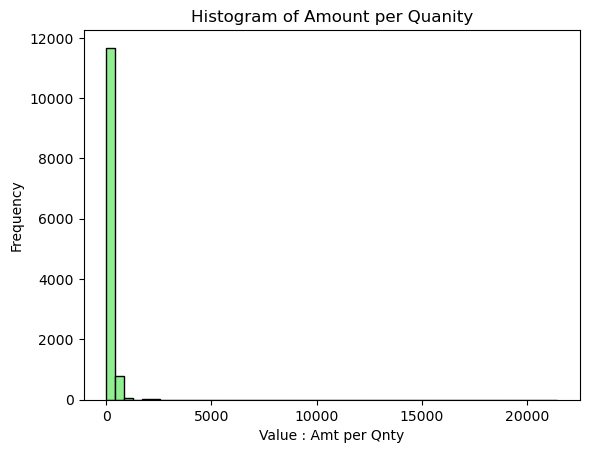

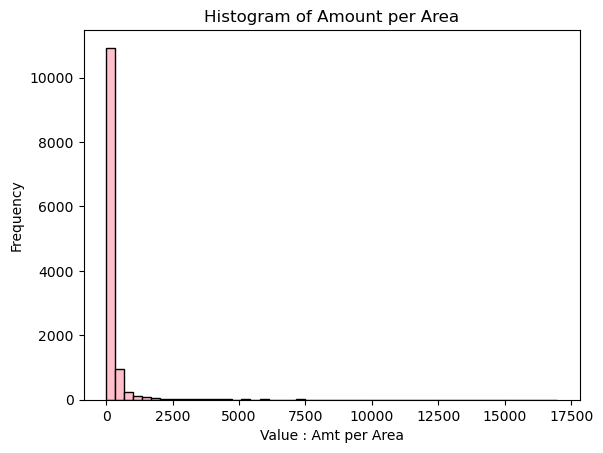

In [13]:
plt.hist(data['Amt_per_Qnty'], bins=50, edgecolor='black', color='lightgreen')
# Add labels and title
plt.xlabel('Value : Amt per Qnty')
plt.ylabel('Frequency')
plt.title('Histogram of Amount per Quanity')
# Show the plot
plt.show()


plt.hist(data['Amt_per_Area'], bins=50, edgecolor='black', color='pink')
# Add labels and title
plt.xlabel('Value : Amt per Area')
plt.ylabel('Frequency')
plt.title('Histogram of Amount per Area')
# Show the plot
plt.show()

Amount or price per Quantity & Amount or price per Area , its a right skewed graph.

In [14]:
print("The median of quantities bought",round(statistics.median(data["QtyRequired"]),0))
plt.show()

The median of quantities bought 8


#### 5. Need to analyse which items are expensive or not and with what quantity are they ordered

             ITEM_NAME  Amt_per_Qnty  QtyRequired
0          DOUBLE BACK    195.947868     9.845689
1                DURRY     66.361820   116.921159
2           GUN TUFTED    173.043889     8.944444
3          HAND TUFTED    216.606815    35.537674
4             HANDLOOM    143.226589    33.904564
5            HANDWOVEN    151.271377    24.237562
6             JACQUARD    159.620321    10.258974
7              KNOTTED    250.324710    12.521472
8  POWER LOOM JACQUARD      8.691667   216.733333
9         TABLE TUFTED     72.900000   297.000000


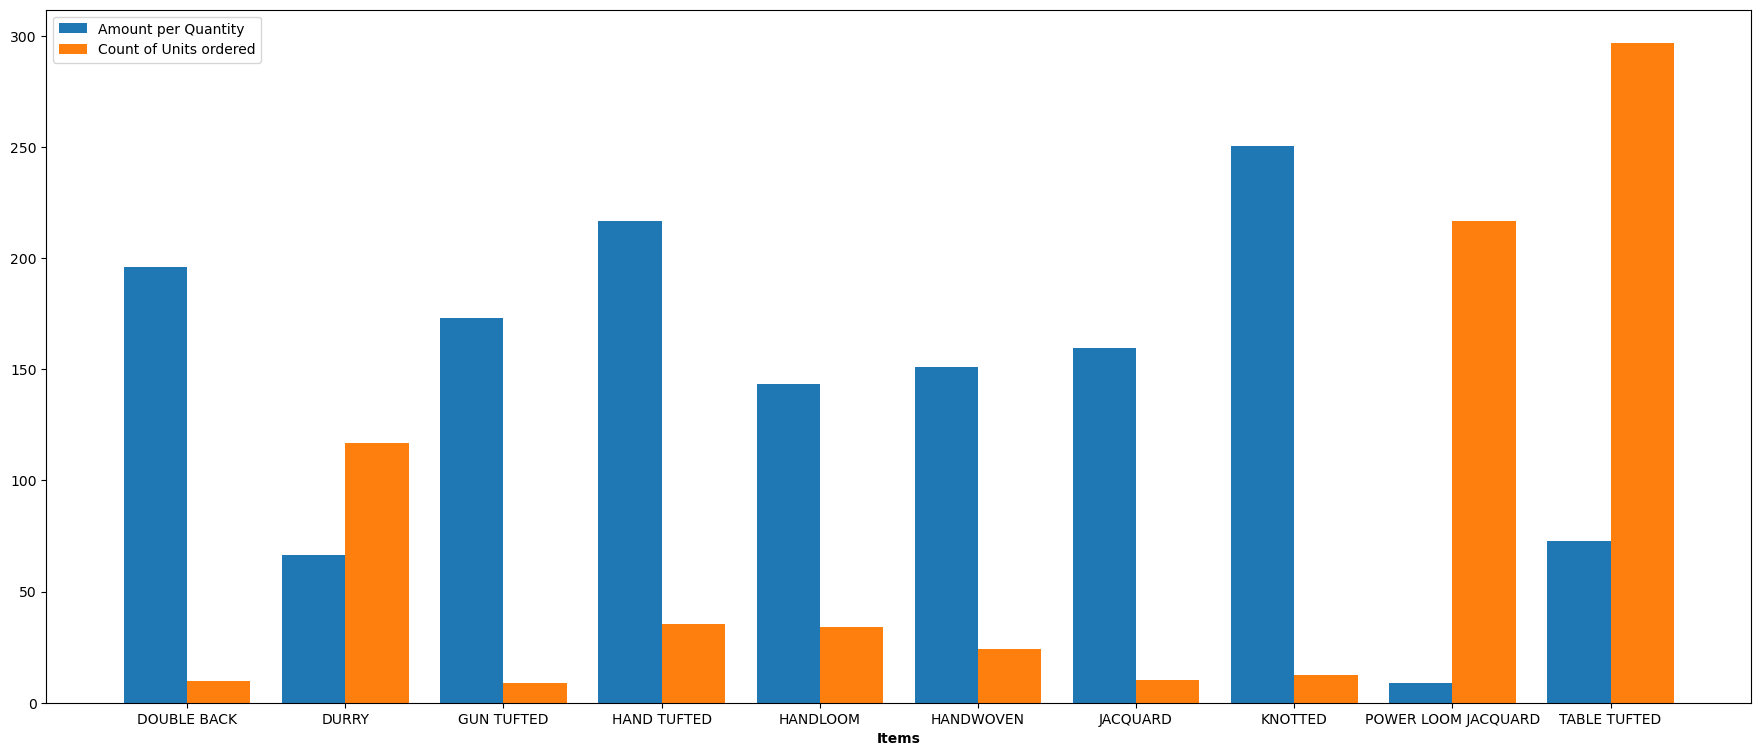

In [15]:
d = data.groupby('ITEM_NAME').agg({'Amt_per_Qnty': 'mean', 'QtyRequired': 'mean'}).reset_index()
print(d)

x = np.arange(len(d['ITEM_NAME']))
y1 = d['Amt_per_Qnty'] 
y2 = d['QtyRequired'] 
width = 0.40
plt.figure(figsize=(22,9))
# plot data in grouped manner of bar type 
plt.bar(x-0.2, y1, width, label='Amount per Quantity') 
plt.bar(x+0.2, y2, width, label='Count of Units ordered') 
plt.xticks(x, ['DOUBLE BACK', 'DURRY', 'GUN TUFTED', 'HAND TUFTED', 'HANDLOOM', 'HANDWOVEN', 'JACQUARD', 'KNOTTED', 
               'POWER LOOM JACQUARD', 'TABLE TUFTED']) 
plt.xlabel("Items",fontweight='bold') 
# Add legend
plt.legend()

# Show the plot
plt.show()

Conclusion : Comparatively Cheaper items like Durry, Table-Tufted, Powerloom Jacquard and Table-Tufted are bought in significantly higher quantity wrt the rest costlier items

# Customer Segmentation

The following features based on customers purchase behavior frequency (number of orders), monetary value from the customers are now created as follows

## Stage 1

In [16]:
df_cust = data.groupby('CustomerCode').agg({'OrderiD':'count', 'Amount':'sum'}).reset_index()
df_cust['Amount'] = round(df_cust['Amount'],2)
df_cust.rename(columns={'OrderiD': 'Order Count'}, inplace=True)
df_cust.head(5)

,CustomerCode,Order Count,Amount
0,A-11,40,185404.10
1,A-6,25,6247.46
2,A-9,1163,1592079.79
3,B-2,47,14811.16
4,B-3,72,58626.86


Scaling the data

In [17]:
warnings.filterwarnings('ignore')
features = df_cust[['Order Count', 'Amount']]

#Scaling the amount and count of orders
num_cols = [
    'Order Count',
    'Amount']
scaler = MinMaxScaler()
#for loop
for col in num_cols:
    df_cust[col] = scaler.fit_transform(df_cust[[col]])
print("Scaled or Normalized data\n")
df_cust.head()

Scaled or Normalized data



,CustomerCode,Order Count,Amount
0,A-11,0.017751,0.016320
1,A-6,0.010924,0.000522
2,A-9,0.528903,0.140357
3,B-2,0.020938,0.001277
4,B-3,0.032317,0.005141


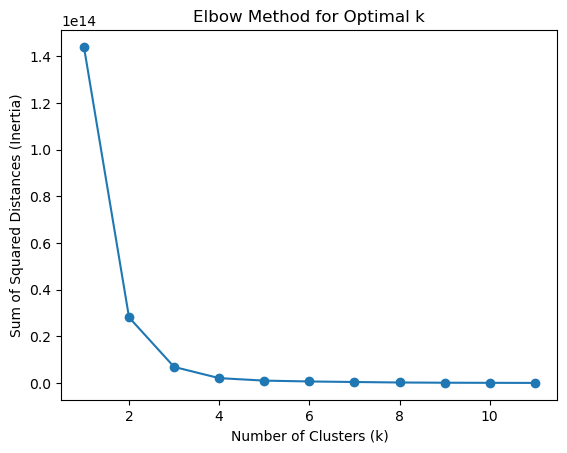

In [18]:
# Choose the number of clusters (we need to experiment with this)
k_values = range(1, 12)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')

# Show the plot
plt.show()

Evaluating the quality of clusters is defined below

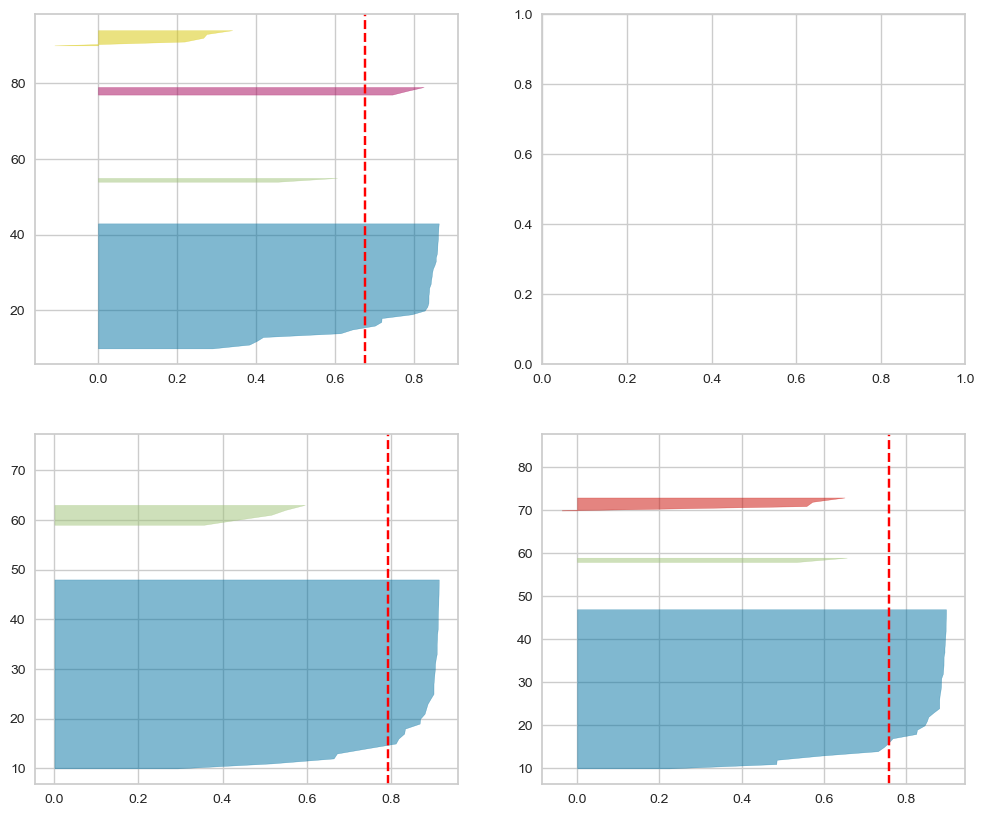

In [19]:
from yellowbrick.cluster import SilhouetteVisualizer

fig, ax = plt.subplots(2, 2, figsize=(12,10))
num_clusters = [3,4,5]
for i, k in enumerate(num_clusters):
    km = KMeans(n_clusters=k, 
                random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, 
                                      colors='yellowbrick', 
                                      ax=ax[q-1][mod])
    visualizer.fit(df_cust[['Order Count', 'Amount']]) 

From the above code and graph we can say that optimal number of clusters , num_clusters = 3, also has highest silhoutte score

### We will approach with K-means clustering for this

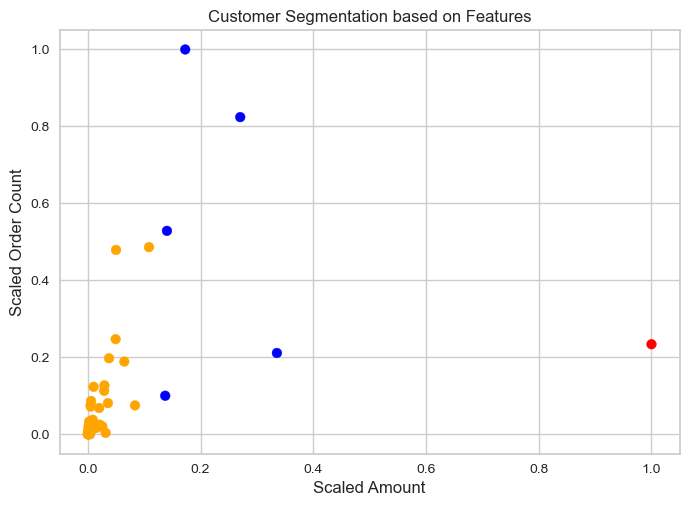

Cluster Centers:
[[1.58974359e+02 2.07540492e+05]
 [5.16000000e+02 1.13410525e+07]
 [1.17220000e+03 2.39604827e+06]]


In [20]:
num_clusters = 3
# Fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_cust['Cluster'] = kmeans.fit_predict(features)

# Visualize the clusters
cluster_colors = ['orange', 'red', 'blue']
plt.scatter(df_cust['Amount'], df_cust['Order Count'], c=df_cust['Cluster'].map(lambda x: cluster_colors[x]), cmap='viridis')
plt.title('Customer Segmentation based on Features')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Order Count')
plt.show()

# Display the cluster centers
print('Cluster Centers:')
print(kmeans.cluster_centers_)

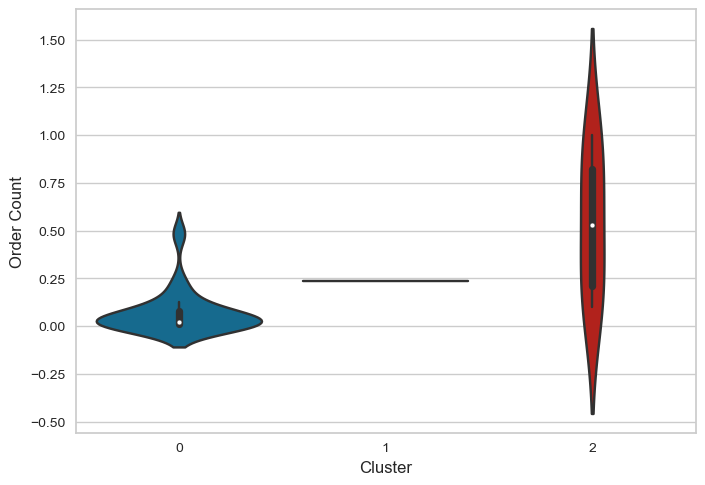

In [21]:
sns.violinplot(data = df_cust,
              y = 'Order Count',
              x = 'Cluster');

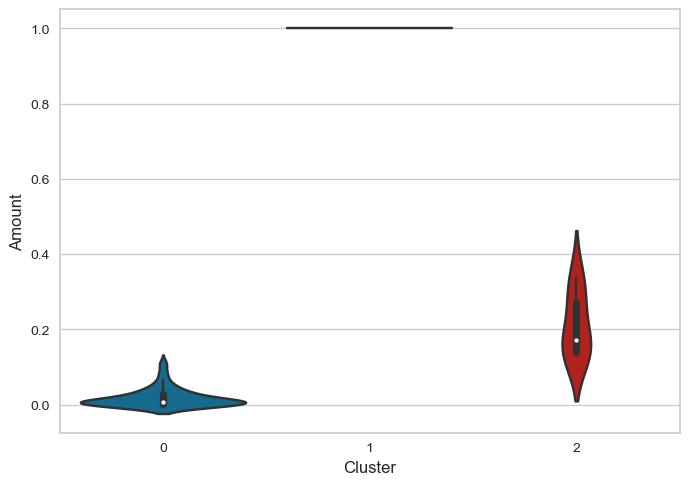

In [22]:
sns.violinplot(data = df_cust,
              y = 'Amount',
              x = 'Cluster');

In [23]:
df_cust = df_cust.sort_values(by = ['Cluster'])
cluster_names = {
    0: 'Low Affluent Consumers',       #because these customers are buying things in relatively low quantity and lower price
    1: 'Moderately Affluent Consumers',#because these customers are buying less expesive things in relatively higher quantity
    2: 'High Affluent Consumers'       #because these customers are buying things in relatively high quantity and higher price
}

df_cust['K-Cluster Name'] = df_cust['Cluster'].map(cluster_names)
print(df_cust.head(5))
print("\n........\n")
print(df_cust.tail(5))

   CustomerCode  Order Count    Amount  Cluster          K-Cluster Name
0          A-11     0.017751  0.016320        0  Low Affluent Consumers
24          L-3     0.012289  0.007974        0  Low Affluent Consumers
25          L-4     0.000455  0.003871        0  Low Affluent Consumers
26          L-5     0.004096  0.031617        0  Low Affluent Consumers
28          M-2     0.127447  0.029444        0  Low Affluent Consumers

........

   CustomerCode  Order Count    Amount  Cluster           K-Cluster Name
27          M-1     1.000000  0.172775        2  High Affluent Consumers
7           C-2     0.100592  0.137275        2  High Affluent Consumers
18          H-2     0.211652  0.335470        2  High Affluent Consumers
2           A-9     0.528903  0.140357        2  High Affluent Consumers
31          P-5     0.824306  0.270370        2  High Affluent Consumers


## Stage 2

### 1. We will approach with Hierarchial Distance Clustering 

In [24]:
from sklearn.cluster import AgglomerativeClustering

In [25]:
h_cluster = AgglomerativeClustering(n_clusters = 3,
                                    metric = 'euclidean',
                                    linkage = 'ward',
                                    compute_distances = True)

In [26]:
h_cluster.fit(df_cust[['Order Count', 'Amount']])

AgglomerativeClustering(compute_distances=True, metric='euclidean',
                        n_clusters=3)

In [27]:
df_cust['hcluster_clusterid'] = h_cluster.labels_
df_cust.sort_values('hcluster_clusterid').head(5)

,CustomerCode,Order Count,Amount,Cluster,K-Cluster Name,hcluster_clusterid
31,P-5,0.824306,0.270370,2,High Affluent Consumers,0
6,C-1,0.479290,0.050023,0,Low Affluent Consumers,0
20,JL,0.486573,0.108552,0,Low Affluent Consumers,0
2,A-9,0.528903,0.140357,2,High Affluent Consumers,0
27,M-1,1.000000,0.172775,2,High Affluent Consumers,0


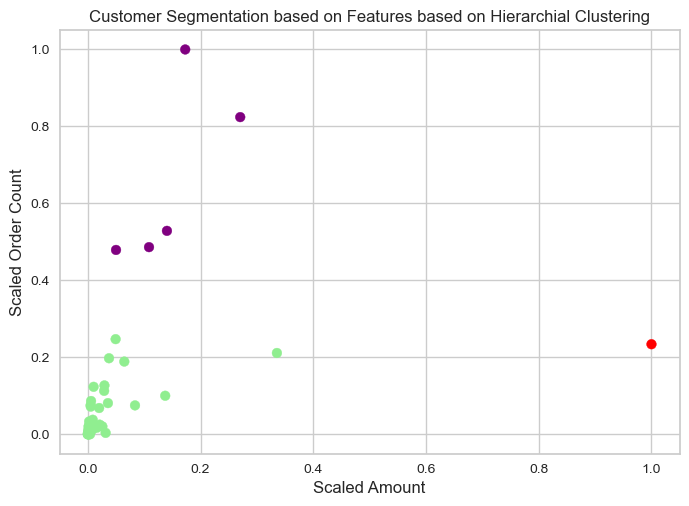

<Figure size 700x400 with 0 Axes>

In [28]:
# Visualize the Hierarchial clusters
cluster_colors = ['purple','lightgreen','red']
plt.scatter(df_cust['Amount'], df_cust['Order Count'], 
            c=df_cust['hcluster_clusterid'].map(lambda x: cluster_colors[x]), cmap='viridis')
 
plt.title('Customer Segmentation based on Features based on Hierarchial Clustering')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Order Count')
plt.figure(figsize=(7, 4))
plt.show()

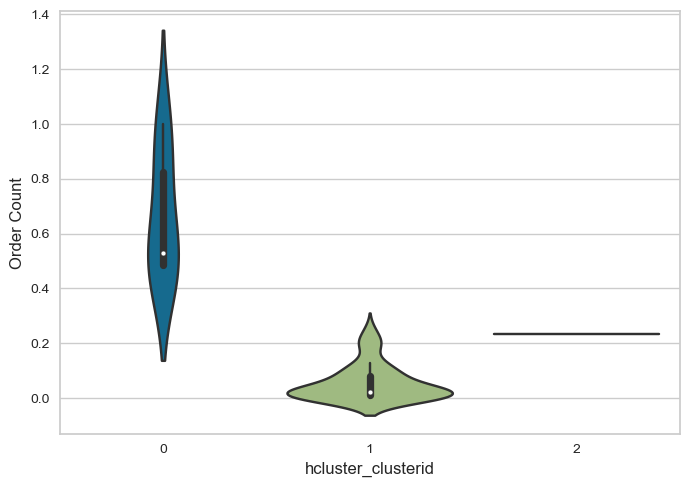

In [29]:
sns.violinplot(data = df_cust,
              y = 'Order Count',
              x = 'hcluster_clusterid');

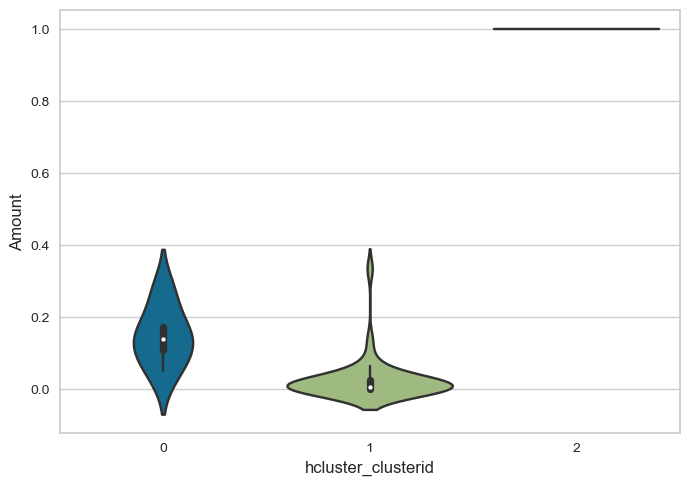

In [30]:
sns.violinplot(data = df_cust,
              y = 'Amount',
              x = 'hcluster_clusterid');

### 2. We will now approach with HDBSCAN density based clustering

In [31]:
from sklearn.cluster import HDBSCAN
hdbscan = HDBSCAN(min_cluster_size=3)
hdbscan.fit(df_cust[['Order Count', 'Amount']])

HDBSCAN(min_cluster_size=3)

In [32]:
hdbscan.labels_
df_cust['hdbscan_clusterid'] = hdbscan.labels_
df_cust.head(10)

,CustomerCode,Order Count,Amount,Cluster,K-Cluster Name,hcluster_clusterid,hdbscan_clusterid
0,A-11,0.017751,0.016320,0,Low Affluent Consumers,1,3
24,L-3,0.012289,0.007974,0,Low Affluent Consumers,1,3
25,L-4,0.000455,0.003871,0,Low Affluent Consumers,1,3
26,L-5,0.004096,0.031617,0,Low Affluent Consumers,1,3
28,M-2,0.127447,0.029444,0,Low Affluent Consumers,1,2
29,N-1,0.075558,0.083685,0,Low Affluent Consumers,1,-1
30,P-4,0.020938,0.025767,0,Low Affluent Consumers,1,3
32,PC,0.068730,0.020071,0,Low Affluent Consumers,1,4
33,PD,0.081475,0.035638,0,Low Affluent Consumers,1,4
34,R-4,0.004096,0.000862,0,Low Affluent Consumers,1,3


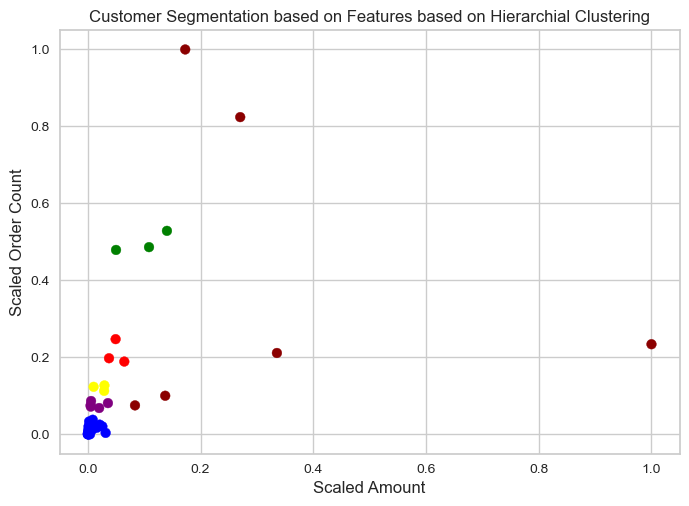

<Figure size 700x400 with 0 Axes>

In [33]:
# Visualize the Hierarchial clusters
cluster_colors = ['green', 'red', 'yellow', 'blue', 'purple', 'pink', 'lightgreen', 'lightblue', 
                  'orange', 'darkred']
plt.scatter(df_cust['Amount'], df_cust['Order Count'], 
            c=df_cust['hdbscan_clusterid'].map(lambda x: cluster_colors[x]), cmap='magma')
 
plt.title('Customer Segmentation based on Features based on Hierarchial Clustering')
plt.xlabel('Scaled Amount')
plt.ylabel('Scaled Order Count')
plt.figure(figsize=(7, 4))
plt.show()

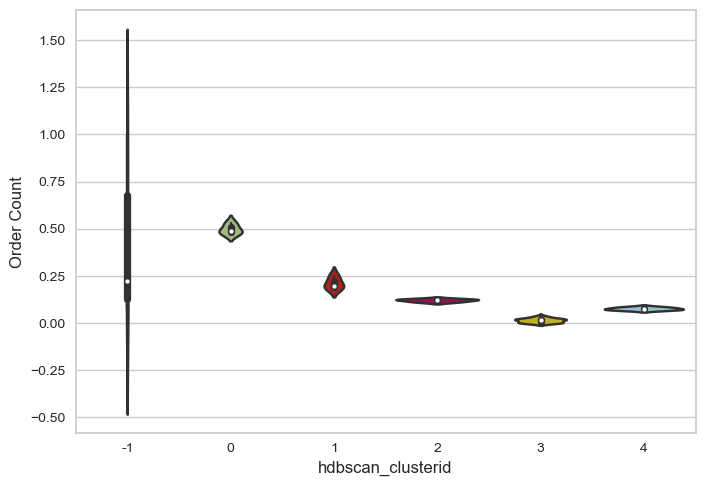

In [34]:
sns.violinplot(data = df_cust,
              y = 'Order Count',
              x = 'hdbscan_clusterid');

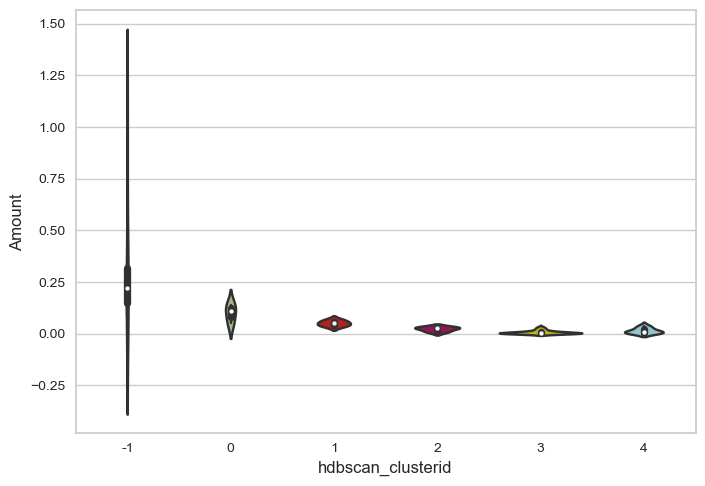

In [35]:
sns.violinplot(data = df_cust,
              y = 'Amount',
              x = 'hdbscan_clusterid');

## Stage 3

#### Added some more features from the above features for example kind of products customers are buying, high value or low value items bought, diversity of items (number of unique items bought) in orders

In [36]:
# Feature scaling
df_Cust_ord = data.groupby('CustomerCode').agg({'Item_Id':'nunique','OrderiD':'nunique', 'Amount':'sum'}).reset_index()
df_Cust_ord.rename(columns = {'Item_Id':'Unique_Items', 'OrderiD':'Unique_Orders'}, inplace = True) 
df_Cust_ord['Amount'] = round(df_Cust_ord['Amount'],2)
df_Cust_ord.head()
#df_Cust_ = data.groupby('CustomerCode').agg({'OrderiD':'count'}).reset_index()
#df_Cust_.rename(columns = {'OrderiD':'Total Order Count'}, inplace = True) 

#df_Cust_ord = df_Cust_ord.append(df_Cust_)

,CustomerCode,Unique_Items,Unique_Orders,Amount
0,A-11,23,11,185404.10
1,A-6,25,2,6247.46
2,A-9,504,205,1592079.79
3,B-2,44,8,14811.16
4,B-3,72,11,58626.86


In [37]:
df_scaled = df_Cust_ord

num_cols = ['Unique_Items', 'Unique_Orders', 'Amount']
scaler_ss = StandardScaler()
#for loop
for col in num_cols:
    df_scaled[col] = scaler_ss.fit_transform(df_Cust_ord[[col]])
print("Scaled or Normalized data\n")
df_scaled.head()

Scaled or Normalized data



,CustomerCode,Unique_Items,Unique_Orders,Amount
0,A-11,-0.627500,-0.363171,-0.286630
1,A-6,-0.615700,-0.447945,-0.386786
2,A-9,2.210409,1.464196,0.499763
3,B-2,-0.503599,-0.391429,-0.381999
4,B-3,-0.338399,-0.363171,-0.357504


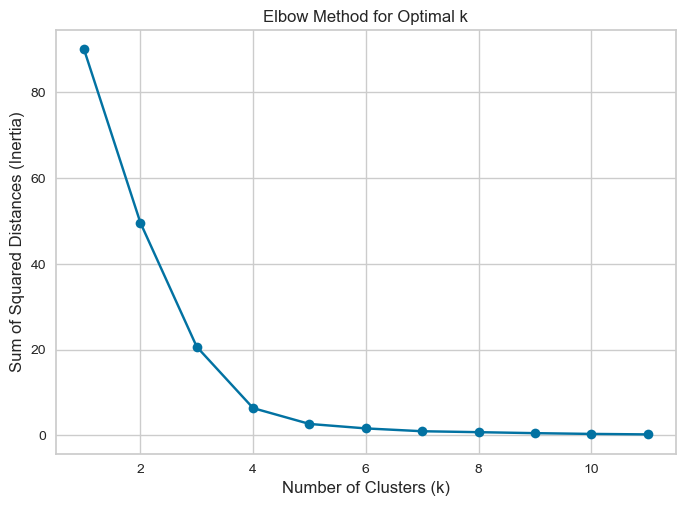

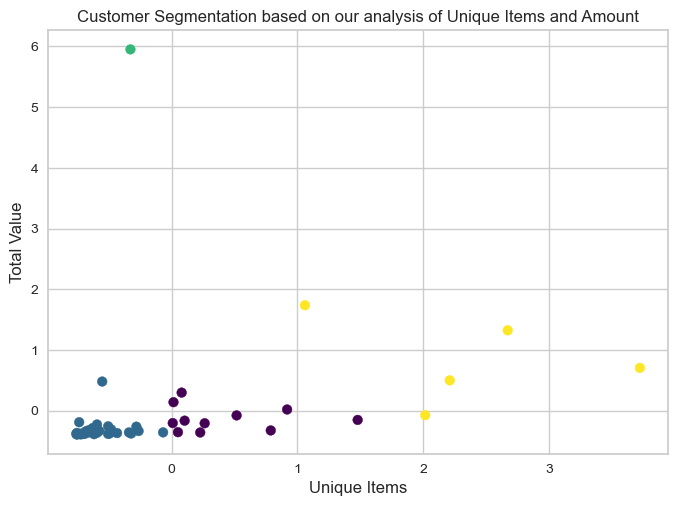

,CustomerCode,Unique_Items,Unique_Orders,Amount,Cluster_1
0,A-11,-0.627500,-0.363171,-0.286630,1
1,A-6,-0.615700,-0.447945,-0.386786,1
2,A-9,2.210409,1.464196,0.499763,3
3,B-2,-0.503599,-0.391429,-0.381999,1
4,B-3,-0.338399,-0.363171,-0.357504,1


In [38]:
k_values = range(1, 12)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[['Unique_Orders','Amount']])
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')

# Show the plot
plt.show()

# Clustering (adjusting the number of clusters based on our analysis of Unique Items and Amount)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_scaled['Cluster_1'] = kmeans.fit_predict(df_scaled[['Unique_Items','Amount']])

# Visualization (2D plot for illustration)
plt.scatter(df_scaled['Unique_Items'],df_scaled['Amount'], c=df_scaled['Cluster_1'], cmap='viridis')
plt.ylabel('Total Value')
plt.xlabel('Unique Items')
plt.title('Customer Segmentation based on our analysis of Unique Items and Amount')
plt.show()

 #Display the DataFrame with clusters
df_scaled.head()

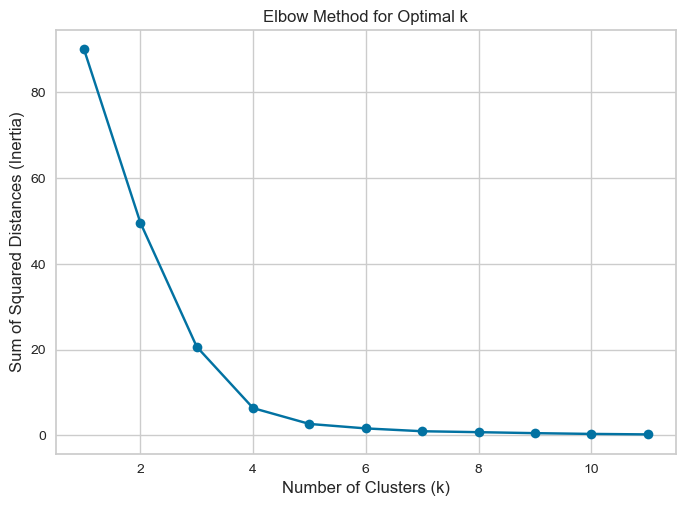

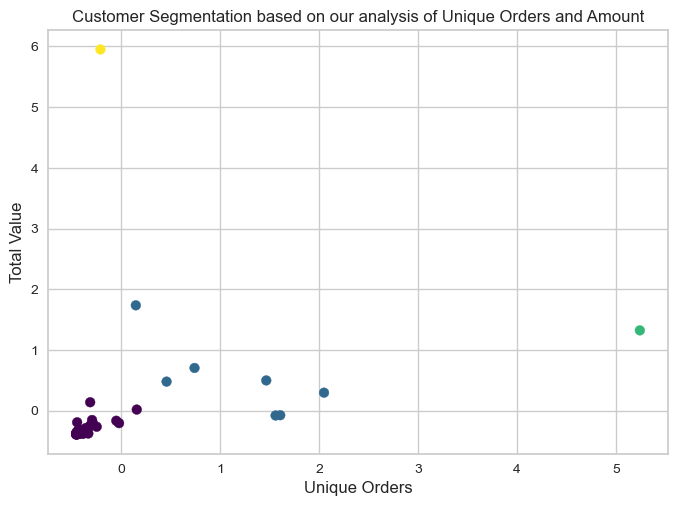

,CustomerCode,Unique_Items,Unique_Orders,Amount,Cluster_1,Cluster_2
0,A-11,-0.627500,-0.363171,-0.286630,1,0
1,A-6,-0.615700,-0.447945,-0.386786,1,0
2,A-9,2.210409,1.464196,0.499763,3,1
3,B-2,-0.503599,-0.391429,-0.381999,1,0
4,B-3,-0.338399,-0.363171,-0.357504,1,0


In [39]:
k_values = range(1, 12)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_scaled[['Unique_Orders','Amount']])
    inertia_values.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')

# Show the plot
plt.show()


# Clustering (adjusting the number of clusters based on our analysis of Unique Orders and Amount)
num_clusters = 4
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_scaled['Cluster_2'] = kmeans.fit_predict(df_scaled[['Unique_Orders','Amount']])

# Visualization (2D plot for illustration)
plt.scatter(df_scaled['Unique_Orders'],df_scaled['Amount'], c=df_scaled['Cluster_2'], cmap='viridis')
plt.ylabel('Total Value')
plt.xlabel('Unique Orders')
plt.title('Customer Segmentation based on our analysis of Unique Orders and Amount')
plt.show()

 #Display the DataFrame with clusters
df_scaled.head()